# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

# A. Methodlogy  🎯
* In this notebook I'll demonstrate **2.5D** image Training for **Segmentation** with `tf.data`, `tfrecord` using `Tensorflow`. 
* In a nutshell, **2.5D Image Training** is training of **3D** image like **2D** Image.  More about **2.5D** training is discussed later. 2.5D images can take leverage of the extra depth information like our typical RGB image. In this notebook I'll be using 3 channels with 2 strides for 2.5D images
* In this notebook, I'll be also re-implementing **[TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation](https://arxiv.org/pdf/2102.04306.pdf)** Model using Tensorflow.
* TFRecord dataset for **Segmentation** is created using [UWMGI: 2.5D TFRecord Data](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-tfrecord-data) notebook.
* TFRecord files are created using **StratifiedGroupFold** to avoid data leakage due to `case` and to stratify `empty` and `non-empty` mask cases.
* This notebook is compatible for both **GPU** and **TPU**. Device is automatically selected so you won't have to do anything to allocate device.
* As there are overlaps between **Stomach**, **Large Bowel** & **Small Bowel** classes, this is a **MultiLabel Segmentation** task, so final activaion should be `sigmoid` instead of `softmax`.
* You can play with different models and losses.

# B. Notebooks 📒
📌 **2.5D-TransUNet**:
* Train: [UWMGI: TransUnet 2.5D [Train] [TF]](https://www.kaggle.com/awsaf49/uwmgi-transunet-2-5d-train-tf/)
<!-- * Infer:  UWMGI: TransUnet 2.5D [Infer] [TF]-->

📌 **Data/Dataset**:
* Mask-Data: [UWMGI: Mask Data](https://www.kaggle.com/code/awsaf49/uwmgi-mask-data)
* Data: [UWMGI: 2.5D TFRecord Data](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-tfrecord-data)
* Dataset: [UWMGI: 2.5D TFRecord Dataset](https://www.kaggle.com/datasets/awsaf49/uwmgi-25d-tfrecord-dataset)

# 1. Install Libraries 🛠
Source code for TransUNet model is [here](https://github.com/awsaf49/TransUNet-tf)

In [1]:
!pip install -q transunet
!pip install -q segmentation_models
!pip install -qU wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tfx-bsl 1.8.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.8.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.4 which is incompatible.
rich 12.4.4 requires typing-exte

# 2. Import Libraries 📚
Let's imoport necessary libraries.

In [2]:
import pandas as pd, numpy as np, random,os, shutil
import tensorflow as tf, re, math
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import sklearn
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow_addons as tfa
import yaml
from IPython import display as ipd
import json
from datetime import datetime

from glob import glob
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from IPython import display as ipd

import scipy
import warnings

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math

# Show less log messages
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Set tf.keras as backend
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

# Set true to show less logging messages
os.environ["WANDB_SILENT"] = "false"
import wandb

Segmentation Models: using `tf.keras` framework.


# 3. Configuration ⚙️

In [3]:
class CFG:
    wandb = True
    competition = "uwmgi-tf"
    _wandb_kernel = "awsaf49"
    debug = False
    exp_name = "v4"
    comment = "TransUNet-EfficientNet-b7"

    # Use verbose=0 for silent, 1 for interactive
    verbose = 0
    display_plot = True

    # Device for training
    device = None  # device is automatically selected

    # Model & Backbone
    model_name = "TransUNet"
    backbone = "efficientnetb7"

    # Seeding for reproducibility
    seed = 101

    # Number of folds
    folds = 5

    # Which Folds to train
    selected_folds = [0, 1, 2, 3, 4]

    # Image Size
    img_size = [128, 128]

    # Batch Size & Epochs
    batch_size = 64
    drop_remainder = False
    epochs = 32
    steps_per_execution = None

    # Loss & Optimizer & LR Scheduler
    loss = "dice_loss"
    optimizer = "Adam"
    lr = 5e-4
    lr_schedule = "ReduceLROnPlateau"
    patience = 5

    # Augmentation
    augment = True
    transform = False

    # Transformation
    fill_mode = "constant"
    rot = 5.0  # proprtional
    shr = 5.0  # proprtional
    hzoom = 100.0  # inv proportional
    wzoom = 100.0  # inv proportional
    hshift = 10.0  # proportional
    wshift = 10.0  # proportional

    # Horizontal & Vertical Flip
    hflip = 0.5
    vflip = 0.5

    # Clip values to [0, 1]
    clip = False

    # CutOut
    drop_prob = 0.5
    drop_cnt = 10
    drop_size = 0.05

    # Jitter
    sat = [0.7, 1.3]  # saturation
    cont = [0.8, 1.2]  # contrast
    bri = 0.15  # brightness
    hue = 0.0  # hue


# 4. Reproducibility ♻️
Sets value for random seed to produce similar result in each run.

In [4]:
def seeding(SEED):
    """
    Sets all random seeds for the program (Python, NumPy, and TensorFlow).
    """
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    os.environ["TF_CUDNN_DETERMINISTIC"] = str(SEED)
    tf.random.set_seed(SEED)
    print("seeding done!!!")


seeding(CFG.seed)

seeding done!!!


# 5. Set Up Device 📱
Following codes automatically detects hardware(tpu or gpu or cpu). 

In [5]:
def configure_device():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # connect to tpu cluster
        strategy = tf.distribute.TPUStrategy(tpu) # get strategy for tpu
        print('> Running on TPU ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device='TPU'
    except: # otherwise detect GPUs
        tpu = None
        gpus = tf.config.list_logical_devices('GPU') # get logical gpus
        ngpu = len(gpus)
        if ngpu: # if number of GPUs are 0 then CPU
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy() # connect to single gpu or cpu
            device='CPU'
    return strategy, device, tpu

In [6]:
strategy, CFG.device, tpu = configure_device()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

2022-06-30 08:51:30.559642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 08:51:30.664018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 08:51:30.664841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 08:51:30.667395: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

> Running on GPU | Num of GPUs:  1
REPLICAS: 1


# 6. Meta Data 📖
* Files
    * `train.csv` - IDs and masks for all training objects.
    * `sample_submission.csv` - a sample submission file in the correct format
    * `train/` - a folder of case/day folders, each containing slice images for a particular case on a given day.

> **Note** that the image filenames include 4 numbers (ex. `276_276_1.63_1.63.png`). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

* Columns
    * `id` - unique identifier for object
    * `class` - the predicted class for the object
    * `EncodedPixels` - RLE-encoded pixels for the identified object

In [7]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

To run code on **TPU** we need our data to be stored on **Google Cloud Storage**. Hence, we'll be needing **GCS_PATH** of our stored data. Worried about how we will get our data stored on **GCS**? "Kaggle to the Rescue" Kaggle provides a **GCS_PATH** for public datasets. Hence we can use it for training our model on **TPU**. Simply we have to use `KaggleDatasets()` to get `GCS_PATH` of our dataset.

In [3]:
BASE_PATH = '/kaggle/input/uw-madison-gi-tract-image-segmentation'
GCS_PATH = KaggleDatasets().get_gcs_path('uwmgi-25d-tfrecord-dataset')
ALL_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/uwmgi/*.tfrec')
print('NUM TFRECORD FILES: {:,}'.format(len(ALL_FILENAMES)))
print('NUM TRAINING IMAGES: {:,}'.format(count_data_items(ALL_FILENAMES)))

NameError: name 'KaggleDatasets' is not defined

# 7. Data Augmentation 🌈
> **Caution:** Unlike classification problem, we have to augment both **image** & **mask** otherwise it'll create faulty data as **mask** won't match its corresponding **image**.

<img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/data_aug/outputs/with_mask/aug_and_mask.png" width=800>

## Used Augmentations
Some Augmentations that were used here are,

* RandomFlip (Left-Right)
<img src="https://dataaspirant.com/wp-content/uploads/2020/08/5-horizontal-flip-technique.png" width=400>

* Random Rotation
<img src="https://dataaspirant.com/wp-content/uploads/2020/08/4-rotation-technique.png" width=500>


* RandomBrightness
<img src="https://affine.ai/wp-content/uploads/2022/02/2.jpg" width=400>

* RndomContrast
<img src="https://affine.ai/wp-content/uploads/2022/02/3.jpg" width=400>

* Zoom
<img src="https://affine.ai/wp-content/uploads/2022/02/16.jpg" width=400>

* Cutout
<img src="https://i.ibb.co/3MKjW0t/cutout.png" width=400>

* Shear
<img src="https://imgaug.readthedocs.io/en/latest/_images/shearx.jpg" width=500>

## Utility

In [9]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd


def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    ref: https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    # returns 3x3 transformmatrix which transforms indicies

    # CONVERT DEGREES TO RADIANS
    # rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.0

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst], axis=0), [3, 3])

    one = tf.constant([1], dtype="float32")
    zero = tf.constant([0], dtype="float32")

    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one, s2, zero, zero, c2, zero, zero, zero, one])
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat(
        [one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one]
    )
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat(
        [one, zero, height_shift, zero, one, width_shift, zero, zero, one]
    )

    return K.dot(
        shear_matrix, K.dot(zoom_matrix, shift_matrix)
    )  # K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))


## Augment Fn

In [10]:
def ShiftScaleRotate(image, mask=None, DIM=CFG.img_size, p=1.0):
    """
    ref: https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    if random_float() > p:
        return image, mask
    if DIM[0] > DIM[1]:
        diff = DIM[0] - DIM[1]
        pad = [diff // 2, diff // 2 + (1 if diff % 2 else 0)]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]], [0, 0]])
        NEW_DIM = DIM[0]
        if mask is not None:
            mask = tf.pad(mask, [[0, 0], [pad[0], pad[1]], [0, 0]])
    elif DIM[0] < DIM[1]:
        diff = DIM[1] - DIM[0]
        pad = [diff // 2, diff // 2 + (1 if diff % 2 else 0)]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0], [0, 0]])
        NEW_DIM = DIM[1]
        if mask is not None:
            mask = tf.pad(mask, [[pad[0], pad[1]], [0, 0], [0, 0]])

    rot = CFG.rot * tf.random.normal([1], dtype="float32")
    shr = CFG.shr * tf.random.normal([1], dtype="float32")
    h_zoom = 1.0 + tf.random.normal([1], dtype="float32") / CFG.hzoom
    w_zoom = 1.0 + tf.random.normal([1], dtype="float32") / CFG.wzoom
    h_shift = CFG.hshift * tf.random.normal([1], dtype="float32")
    w_shift = CFG.wshift * tf.random.normal([1], dtype="float32")

    transformation_matrix = tf.linalg.inv(
        get_mat(shr, h_zoom, w_zoom, h_shift, w_shift)
    )
    flat_tensor = tfa.image.transform_ops.matrices_to_flat_transforms(
        transformation_matrix
    )
    rotation = math.pi * rot / 180.0

    image = tfa.image.transform(image, flat_tensor, fill_mode=CFG.fill_mode)
    image = tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)
    if mask is not None:
        mask = tfa.image.transform(mask, flat_tensor, fill_mode=CFG.fill_mode)
        mask = tfa.image.rotate(mask, -rotation, fill_mode=CFG.fill_mode)

    if DIM[0] > DIM[1]:
        image = tf.reshape(image, [NEW_DIM, NEW_DIM, 3])
        image = image[:, pad[0] : -pad[1], :]
        if mask is not None:
            mask = tf.reshape(mask, [NEW_DIM, NEW_DIM, 3])
            mask = mask[:, pad[0] : -pad[1], :]
    elif DIM[1] > DIM[0]:
        image = tf.reshape(image, [NEW_DIM, NEW_DIM, 3])
        image = image[pad[0] : -pad[1], :, :]
        if mask is not None:
            mask = tf.reshape(mask, [NEW_DIM, NEW_DIM, 3])
            mask = mask[pad[0] : -pad[1], :, :]

    image = tf.reshape(image, [*DIM, 3])
    if mask is not None:
        mask = tf.reshape(mask, [*DIM, 3])
    return image, mask


def CutOut(image, mask=None, DIM=CFG.img_size, PROBABILITY=0.6, CT=5, SZ=0.1):
    """
    ref: https://www.kaggle.com/code/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout
    """
    # Input Image - is with shape [dim,dim,3] not of [None,dim,dim,3]
    # Probability
    P = tf.cast(random_float() < PROBABILITY, tf.int32)
    if (P == 0) | (CT == 0) | (SZ == 0):
        return image, mask
    # Iterate Through Each Sample of Batch
    for k in range(CT):
        # Choose Random Location
        x = tf.cast(tf.random.uniform([], 0, DIM[1]), tf.int32)
        y = tf.cast(tf.random.uniform([], 0, DIM[0]), tf.int32)
        # Compute Square for CutOut
        WIDTH = tf.cast(SZ * min(DIM), tf.int32) * P
        ya = tf.math.maximum(0, y - WIDTH // 2)
        yb = tf.math.minimum(DIM[0], y + WIDTH // 2)
        xa = tf.math.maximum(0, x - WIDTH // 2)
        xb = tf.math.minimum(DIM[1], x + WIDTH // 2)
        # CutOut Image
        one = image[ya:yb, 0:xa, :]
        two = tf.zeros([yb - ya, xb - xa, 3], dtype=image.dtype)
        three = image[ya:yb, xb : DIM[1], :]
        middle = tf.concat([one, two, three], axis=1)
        image = tf.concat([image[0:ya, :, :], middle, image[yb : DIM[0], :, :]], axis=0)
        image = tf.reshape(image, [*DIM, 3])
        # CutOut Mask
        if mask is not None:
            one = mask[ya:yb, 0:xa, :]
            two = tf.zeros([yb - ya, xb - xa, 3], dtype=mask.dtype)  # ch=3
            three = mask[ya:yb, xb : DIM[1], :]
            middle = tf.concat([one, two, three], axis=1)
            mask = tf.concat(
                [mask[0:ya, :, :], middle, mask[yb : DIM[0], :, :]], axis=0
            )
            mask = tf.reshape(mask, [*DIM, 3])  # ch=3
    return image, mask


def RandomJitter(img, hue, sat, cont, bri, p=1.0):
    if random_float() > p:
        return img
    img = tf.image.random_hue(img, hue)
    img = tf.image.random_saturation(img, sat[0], sat[1])
    img = tf.image.random_contrast(img, cont[0], cont[1])
    img = tf.image.random_brightness(img, bri)
    return img


def RandomFlip(img, msk=None, hflip_p=0.5, vflip_p=0.5):
    if random_float() < hflip_p:
        img = tf.image.flip_left_right(img)
        if msk is not None:
            msk = tf.image.flip_left_right(msk)
    if random_float() < vflip_p:
        img = tf.image.flip_up_down(img)
        if msk is not None:
            msk = tf.image.flip_up_down(msk)
    return img, msk

# 8. Data Pipeline 🍚

## 2.5D Training
**What is 2.5D Training?**

Even though we can do easy straight-forward 2D training, we can utilize ct slices for extra depth information. For example, we can stack consecutive slices of the scans to get a 3D volume. But one of the reasons why I'm inferring them as 2.5D is that we'll be training 3D images like 2D images. Those who haven't come across this method may get confused at first but let me explain. When we train 2D images like RGB images we actually pass a 3D tensor ex:`[None, channel, height, width]` to a model. For PyTorch, the last two dimensions are spacial(height & width) and the first one is the **channel** dimension. Now for the ct image, we don't have any channel information so we can use that dimension to **stack multiple ct scans as channels and train them as 2d images**. 

This method has some cool advantages over 3D training for instance,
* Low GPU/memory cost.
* Simple pipeline.
* Easier augmentation.
* Quick inference.
* Many open-source models.

In my notebook, I've stacked 3 slices with stride=2, you can check the demo image above for example. It kinda looks like **3d movie scene in the theatre**. 

<div align=center><img src="https://i.ibb.co/sgsPf4v/Capture.png" width=800></div>
<div align=center><img src="https://i.ibb.co/KKtZ7Gn/Picture1-3d.png" width=500></div>

## Reading TFRecord Data
**What is TFRecord & Why use it for Segmentation?**

* The `.tfrecord`/`.tfrec` format is TensorFlow's custom data format which is used for storing a sequence of binary records.
* For **Segmentation** unlike any other data formatk in `.tfrecord` we don't have to the read file twice (one for image and one for mask). In `tfrecord` we just have to read file once and we can access both image and mask.
* TFRecord consumes **less storage on disk**, and has **faster read and write time from the disk**, which makes it suitable for **segmentation** task.
* Apart from that there are a number of advantages to using TFRecords: 
    * Efficient usage of storage.
    * Better I/O Speed.
    * TPUs require that you pass data to them in TFRecord format
    
**How TFRecord is created for Segmentation?**

* Mask is stored in `tfrecord` exactly the same way as a image that is as a byte-string. 
* So, you can easily access the both image and mask from example_proto using `exmple["image"]` & `example["mask"]`. 
* Then, to decode it to `tf.Tensor` simply we can use `tf.io.decode_raw()` function.
* For more information, checout [UWMGI: 2.5D TFRecord Data](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-tfrecord-data) notebook.

In [11]:
# Decode image from bytestring to tensor
def decode_image(data, height, width, target_size=CFG.img_size):
    img = tf.io.decode_raw(data, out_type=tf.uint16)
    img = tf.reshape(img, [height, width, 3])  # explicit size needed for TPU
    img = tf.cast(img, tf.float32)
    img = tf.math.divide_no_nan(img, tf.math.reduce_max(img))  # scale image to [0, 1]
    img = tf.image.resize_with_pad(
        img, target_size[0], target_size[1], method="nearest"
    )  # resize with pad to avoid distortion
    img = tf.reshape(img, [*target_size, 3])  # reshape after resize
    return img


# Decode mask from bytestring to tensor
def decode_mask(data, height, width, target_size=CFG.img_size):
    msk = tf.io.decode_raw(data, out_type=tf.uint8)
    msk = tf.reshape(msk, [height, width, 3])  # explicit size needed for TPU
    msk = tf.cast(msk, tf.float32)
    msk = msk / 255.0  # scale mask data to[0, 1]
    msk = tf.image.resize_with_pad(
        msk, target_size[0], target_size[1], method="nearest"
    )
    msk = tf.reshape(msk, [*target_size, 3])  # reshape after resize
    return msk


# Read tfrecord data & parse it & do augmentation
def read_tfrecord(example, augment=True, return_id=False, dim=CFG.img_size):
    tfrec_format = {
        "id": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string means bytestring
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "mask": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(
        example, tfrec_format
    )  # parses a single example proto.
    image_id = example["id"]
    height = example["height"]
    width = example["width"]
    img = decode_image(example["image"], height, width, dim)  # access image
    msk = decode_mask(example["mask"], height, width, dim)  # access mask
    if augment:  # do augmentation
        img, msk = ShiftScaleRotate(img, msk, DIM=dim, p=0.75)
        img, msk = RandomFlip(img, msk, hflip_p=CFG.hflip, vflip_p=CFG.vflip)
        img = RandomJitter(img, CFG.hue, CFG.sat, CFG.cont, CFG.bri, p=0.8)
        img, msk = CutOut(
            img,
            msk,
            DIM=dim,
            PROBABILITY=CFG.drop_prob,
            CT=CFG.drop_cnt,
            SZ=CFG.drop_size,
        )
    img = tf.clip_by_value(img, 0, 1) if CFG.clip else img
    img = tf.reshape(img, [*dim, 3])
    msk = tf.reshape(msk, [*dim, 3])
    return (img, msk) if not return_id else (img, image_id, msk)


## Pipeline with **tf.data**
<div align=center> <img src="https://storage.googleapis.com/jalammar-ml/tf.data/images/tf.data.png" width=700></div>

To build data pipeline using `tfrecrod/tfrec`, we need to use `tf.data` API.

* We can build complex input pipelines from simple, reusable pieces using`tf.data` API . For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random transformation/augmentation to each image, and merge randomly selected images into a batch for training.
* Moreover `tf.data` API provides a `tf.data.Dataset` feature that represents a sequence of components where each component comprises one or more pieces. For instances, in an image pipeline, an component might be a single training example, with a pair of tensor pieces representing the image and its label.

Checkout this [doc](https://www.tensorflow.org/guide/data) if you want to learn more about `tf.data`.

## Pipeline
* Read **TFRecord** files.
* `cache` data to speed up the training.
* `repeat` the data stream (for training only & test-time augmentation).
* `shuffle` the data (for training only).
* Unparse **tfrecord** data & convert it to Image data from ByteString.
* Process Image & Mask.
* Apply Augmentations.
* Batch Data.

In [12]:
def get_dataset(
    filenames,
    shuffle=True,
    repeat=True,
    augment=True,
    cache=True,
    return_id=False,
    batch_size=CFG.batch_size * REPLICAS,
    target_size=CFG.img_size,
    drop_remainder=False,
    seed=CFG.seed,
):
    dataset = tf.data.TFRecordDataset(
        filenames, num_parallel_reads=AUTO
    )  # read tfrecord files
    if cache:
        dataset = dataset.cache()  # cache data for speedup
    if repeat:
        dataset = dataset.repeat()  # repeat the data (for training only)
    if shuffle:
        dataset = dataset.shuffle(
            1024, seed=seed
        )  # shuffle the data (for training only)
        options = tf.data.Options()
        options.experimental_deterministic = (
            False  # order won't be maintained when we shuffle
        )
        dataset = dataset.with_options(options)
    dataset = dataset.map(
        lambda x: read_tfrecord(
            x,
            augment=augment,  # unparse tfrecord data with masks
            return_id=return_id,
            dim=target_size,
        ),
        num_parallel_calls=AUTO,
    )
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)  # batch the data
    dataset = dataset.prefetch(AUTO)  # prefatch data for speedup
    return dataset

# 9. Visualization 🔭
To ensure our pipeline is generating **image** and **mask** correctly, we'll check some samples from a batch.

In [13]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def display_batch(batch, row=2, col=5):
    imgs, msks = batch
    plt.figure(figsize=(2.5*col, 2.5*row))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        img = imgs[idx].numpy()*255.0
        img = img.astype('uint8')
        for i in range(3):
            img[...,i] = clahe.apply(img[...,i])
        ax.imshow(img, cmap='bone')
        msk = msks[idx].numpy()
        ax.imshow(msk,alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout();
    plt.show();

2022-06-30 08:51:34.762446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-30 08:51:44.853090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 972 of 1024
2022-06-30 08:51:44.886358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


image_shape: (20, 128, 128, 3) mask_shape:(20, 128, 128, 3)
image_dtype: <dtype: 'float32'> mask_dtype: <dtype: 'float32'>


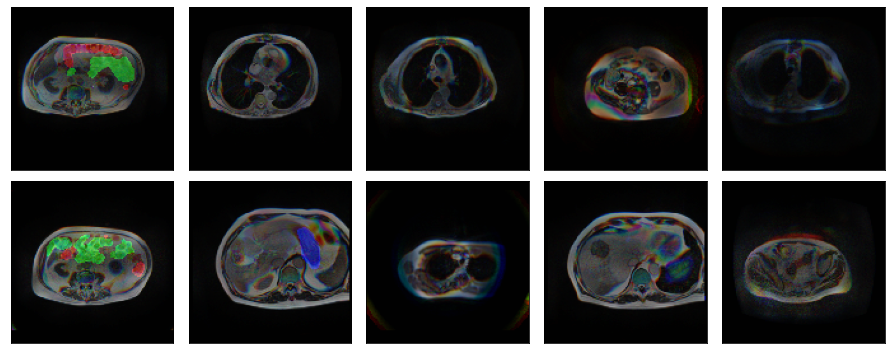

In [14]:
ds = get_dataset(ALL_FILENAMES[:2], augment=False, cache=False, repeat=False).take(1)
batch = next(iter(ds.unbatch().batch(20)))
img, msk = batch
print(f'image_shape: {img.shape} mask_shape:{msk.shape}')
print(f'image_dtype: {img.dtype} mask_dtype: {msk.dtype}')
display_batch(batch)

# 10. Loss Fn 📉
Some implemented loss_functions are,
* Dice Loss
$$ 
Dice = \frac{2\cdot{TP}}{2\cdot{TP} + FP + FN}
$$
* Tversky Loss (Modified IoU Loss)
$$ 
IoU = \frac{TP}{TP + FP + FN}
$$
$$
Tversky = \frac{TP}{TP + \alpha\cdot{FP} + \beta\cdot{FN}}
$$
* Focal Tversky Loss (Focal Loss + Tversky Loss)
$$ 
FocalTversky = (1 - Tversky)^\gamma
$$

In [15]:
from segmentation_models.base import functional as F
import tensorflow.keras.backend as K

kwargs = {}
kwargs["backend"] = K  # set tensorflow.keras as backend


def dice_coef(y_true, y_pred):
    """Dice coefficient"""
    dice = F.f_score(
        y_true,
        y_pred,
        beta=1,
        smooth=1e-5,
        per_image=False,
        threshold=0.5,
        **kwargs,
    )
    return dice


def tversky(y_true, y_pred, axis=(0, 1, 2), alpha=0.3, beta=0.7, smooth=0.0001):
    "Tversky metric"
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.math.reduce_sum(y_true * y_pred, axis=axis) # calculate True Positive
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=axis) # calculate False Negative
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=axis) # calculate False Positive
    tv = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) # calculate tversky
    tv = tf.math.reduce_mean(tv)
    return tv


def tversky_loss(y_true, y_pred):
    "Tversky Loss"
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    "Focal Tversky Loss: Focal Loss + Tversky Loss"
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)


# Register custom objects
custom_objs = {
    "dice_loss": sm.losses.dice_loss,
    "dice_coef": dice_coef,
    "bce_dice_loss": sm.losses.bce_dice_loss,
    "bce_jaccard_loss": sm.losses.bce_jaccard_loss,
    "tversky_loss": tversky_loss,
    "focal_tversky_loss": focal_tversky_loss,
    "jaccard_loss": sm.losses.jaccard_loss,
    "precision": sm.metrics.precision,
    "recall": sm.metrics.recall,
}
tf.keras.utils.get_custom_objects().update(custom_objs)

# 11. LR Schedule ⚓
* Learning Rate scheduler for transfer learning. 
* The learning rate starts from `initial_learning_rate`, then decreases to a`minimum_learning_rate` using different methods namely,
    * **ReduceLROnPlateau**: Reduce lr when score isn't improving.
    * **CosineDecay**: Follow Cosine graph to reduce lr.
    * **ExponentialDecay**: Reduce lr exponentially.

In [16]:
def get_lr_callback():
    if CFG.lr_schedule == "ReduceLROnPlateau":
        lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=int(CFG.patience / 2),
            min_lr=CFG.lr / 1e2,
        )
    elif CFG.lr_schedule == "CosineDecay":
        lr_schedule = tf.keras.experimental.CosineDecay(
            initial_learning_rate=CFG.lr, decay_steps=CFG.epochs + 2, alpha=CFG.lr / 1e2
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    elif CFG.lr_schedule == "ExponentialDecay":
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=CFG.lr,
            decay_steps=CFG.epochs + 2,
            decay_rate=0.05,
            staircase=False,
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    return lr_schedule

# 12. TransUnet 🤖
> [TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation](https://arxiv.org/pdf/2102.04306.pdf)

In a nutshell, this work shows how to convert a **UNet** into a so-called **TransUNet** by using a visual transformer (ViT) network in the encoder. Details of the architecture are in Figure below. As opposed to other methods which use a pure **transformer-based encoder** to convert the input image into a latent vector. A series of convolutions (much like in the original UNet) is used to convert the input image into a set of lower-resolution feature maps which are then encode with a ViT.
So, main components fo **TransUNet** are,

1. Encoder (Pure or Hybrid)
    * CNN
    * Transformer
2. Decoder
    * CNN
3. Skip Connection in Hybrid
    * Connection betwween CNN Encoder & CNN Decoder

> **Codes below are adapted from [here](https://github.com/kenza-bouzid/TransUnet)**

<img src="https://production-media.paperswithcode.com/social-images/hfPJrzzvUuaeIMvb.png" width=800>

## Utils
* Utility code to load `imagenet` weights

In [17]:
def apply_embedding_weights(target_layer, source_weights):
    """Apply embedding weights to a target layer.

    Args:
        target_layer: The target layer to which weights will
            be applied.
        source_weights: The source weights, which will be
            resized as necessary.
    """
    expected_shape = target_layer.weights[0].shape
    if expected_shape == source_weights.shape:
        grid = source_weights
    elif expected_shape[1] == source_weights.shape[1] - 1:
        grid = source_weights[:, 1:]
    else:
        _, grid = source_weights[0, :1], source_weights[0, 1:]
        sin = int(np.sqrt(grid.shape[0]))
        sout = int(np.sqrt(expected_shape[1]))
        warnings.warn(
            "Resizing position embeddings from " f"{sin} to {sout}",
            UserWarning,
        )
        zoom = (sout / sin, sout / sin, 1)
        grid = scipy.ndimage.zoom(grid.reshape(sin, sin, -1), zoom, order=1).reshape(
            1, sout * sout, -1
        )
    target_layer.set_weights([grid])


def load_weights_numpy(model, params_path):
    """Load weights saved using Flax as a numpy array.

    Args:
        model: A Keras model to load the weights into.
        params_path: Filepath to a numpy archive.
    """
    params_dict = np.load(
        params_path, allow_pickle=False
    )  # pylint: disable=unexpected-keyword-arg
    source_keys = list(params_dict.keys())

    source_keys_used = []
    n_transformers = len(
        set(
            "/".join(k.split("/")[:2])
            for k in source_keys
            if k.startswith("Transformer/encoderblock_")
        )
    )
    n_transformers_out = sum(
        l.name.startswith("Transformer/encoderblock_") for l in model.layers
    )
    assert n_transformers == n_transformers_out, (
        f"Wrong number of transformers ("
        f"{n_transformers_out} in model vs. {n_transformers} in weights)."
    )

    matches = []
    for tidx in range(n_transformers):
        encoder = model.get_layer(f"Transformer/encoderblock_{tidx}")
        source_prefix = f"Transformer/encoderblock_{tidx}"
        matches.extend(
            [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/{norm}/{name}" for name in ["scale", "bias"]
                    ],
                }
                for norm, layer in [
                    ("LayerNorm_0", encoder.layernorm1),
                    ("LayerNorm_2", encoder.layernorm2),
                ]
            ]
            + [
                {
                    "layer": encoder.mlpblock.get_layer(
                        f"{source_prefix}/Dense_{mlpdense}"
                    ),
                    "keys": [
                        f"{source_prefix}/MlpBlock_3/Dense_{mlpdense}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                }
                for mlpdense in [0, 1]
            ]
            + [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/MultiHeadDotProductAttention_1/{attvar}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                    "reshape": True,
                }
                for attvar, layer in [
                    ("query", encoder.att.query_dense),
                    ("key", encoder.att.key_dense),
                    ("value", encoder.att.value_dense),
                    ("out", encoder.att.combine_heads),
                ]
            ]
        )

    # Embedding kernel and bias
    matches.append(
        {
            "layer": model.get_layer("embedding"),
            "keys": [f"embedding/{name}" for name in ["kernel", "bias"]],
        }
    )

    matches.append(
        {
            "layer": model.get_layer("Transformer/encoder_norm"),
            "keys": [f"Transformer/encoder_norm/{name}" for name in ["scale", "bias"]],
        }
    )
    apply_embedding_weights(
        target_layer=model.get_layer("Transformer/posembed_input"),
        source_weights=params_dict["Transformer/posembed_input/pos_embedding"],
    )
    source_keys_used.append("Transformer/posembed_input/pos_embedding")
    for match in matches:
        source_keys_used.extend(match["keys"])
        source_weights = [params_dict[k] for k in match["keys"]]
        if match.get("reshape", False):
            source_weights = [
                source.reshape(expected.shape)
                for source, expected in zip(
                    source_weights, match["layer"].get_weights()
                )
            ]
        match["layer"].set_weights(source_weights)

## Encoder
Key components of Encoder are,
* AddPositionEmbs
* MultiHeadSelfAttention
* TransformerBlock
* ResNet_Embeddings

In [18]:
class AddPositionEmbs(tfkl.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, trainable=True, **kwargs):
        super().__init__(trainable=trainable, **kwargs)
        self.trainable = trainable

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2])
            ),
            dtype="float32",
            trainable=self.trainable,
        )

    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)


class MultiHeadSelfAttention(tfkl.Layer):
    def __init__(self, *args, trainable=True, n_heads, **kwargs):
        super().__init__(trainable=trainable, *args, **kwargs)
        self.n_heads = n_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        n_heads = self.n_heads
        if hidden_size % n_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {n_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // n_heads
        self.query_dense = tfkl.Dense(hidden_size, name="query")
        self.key_dense = tfkl.Dense(hidden_size, name="key")
        self.value_dense = tfkl.Dense(hidden_size, name="value")
        self.combine_heads = tfkl.Dense(hidden_size, name="out")

    # pylint: disable=no-self-use
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.n_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights


class TransformerBlock(tfkl.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, n_heads, mlp_dim, dropout, trainable=True, **kwargs):
        super().__init__(*args, trainable=trainable, **kwargs)
        self.n_heads = n_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            n_heads=self.n_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tfk.Sequential(
            [
                tfkl.Dense(
                    self.mlp_dim, activation="linear", name=f"{self.name}/Dense_0"
                ),
                tfkl.Lambda(lambda x: tfk.activations.gelu(x, approximate=False))
                if hasattr(tfk.activations, "gelu")
                else tfkl.Lambda(lambda x: tfa.activations.gelu(x, approximate=False)),
                tfkl.Dropout(self.dropout),
                tfkl.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tfkl.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_0")
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_2")
        self.dropout = tfkl.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights


def resnet_embeddings(x, image_size=224, n_skip=3):
    """Get resnet embeddings for Decoder"""
    resnet50v2 = tfk.applications.ResNet50V2(
        weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3)
    )
    _ = resnet50v2(x)
    layers = ["conv3_block4_preact_relu", "conv2_block3_preact_relu", "conv1_conv"]
    features = []
    if n_skip > 0:
        for l in layers:
            features.append(resnet50v2.get_layer(l).output)
    return resnet50v2, features

## Decoder
Key components of Decoders are,
* SegmentationHead
* Conv2DReLu
* DecoderBlock
* DecoderCup

In [19]:
L2_WEIGHT_DECAY = 1e-4


class SegmentationHead(tfkl.Layer):
    def __init__(
        self,
        name="seg_head",
        num_classes=9,
        kernel_size=1,
        final_act="sigmoid",
        **kwargs
    ):
        super(SegmentationHead, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.kernel_size = kernel_size
        self.final_act = final_act

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.num_classes,
            kernel_size=self.kernel_size,
            padding="same",
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer=tfk.initializers.LecunNormal(),
        )
        self.act = tfkl.Activation(self.final_act)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.act(x)
        return x


class Conv2DReLu(tfkl.Layer):
    def __init__(self, filters, kernel_size, padding="same", strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.strides = strides

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            use_bias=False,
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer="lecun_normal",
        )

        self.bn = tfkl.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)
        return x


class DecoderBlock(tfkl.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.conv2 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.upsampling = tfkl.UpSampling2D(size=2, interpolation="bilinear")

    def call(self, inputs, skip=None):
        x = self.upsampling(inputs)
        if skip is not None:
            x = tf.concat([x, skip], axis=-1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DecoderCup(tfkl.Layer):
    def __init__(self, decoder_channels, n_skip=3, **kwargs):
        super().__init__(**kwargs)
        self.decoder_channels = decoder_channels
        self.n_skip = n_skip

    def build(self, input_shape):
        self.conv_more = Conv2DReLu(filters=512, kernel_size=3)
        self.blocks = [DecoderBlock(filters=out_ch) for out_ch in self.decoder_channels]

    def call(self, hidden_states, features):
        x = self.conv_more(hidden_states)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x


## Model
* Merge Encoder & Decoder part of TransUNet Model.
* You can also ditch so many lines of code above for **TransUNet** model and load model directly using simple two lines of code,
```py
from transunet import TransUNet
model = TransUNet(image_size=224, pretrain=True)
```

In [20]:
MODELS_URL = "https://storage.googleapis.com/vit_models/imagenet21k/"


def load_pretrained(model, fname="R50+ViT-B_16.npz"):
    """Load model weights for a known configuration."""
    origin = MODELS_URL + fname
    local_filepath = tf.keras.utils.get_file(fname, origin, cache_subdir="weights")
    load_weights_numpy(model, local_filepath)


def TransUNet(
    image_size=224,
    patch_size=16,
    hybrid=True,
    grid=(14, 14),
    resnet_n_layers=(3, 4, 9),
    hidden_size=768,
    n_layers=12,
    n_heads=12,
    mlp_dim=3072,
    dropout=0.1,
    decoder_channels=[256, 128, 64, 16],
    n_skip=3,
    num_classes=3,
    final_act="sigmoid",
    pretrain=True,
    freeze_enc_cnn=True,
    name="TransUNet",
):
    # Tranformer Encoder
    assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
    x = tf.keras.layers.Input(shape=(image_size, image_size, 3))

    #  CNN + Transformer
    if hybrid:
        grid_size = grid
        patch_size = image_size // 16 // grid_size[0]
        if patch_size == 0:
            patch_size = 1
        resnet50v2, features = resnet_embeddings(
            x, image_size=image_size, n_skip=n_skip
        )
        if freeze_enc_cnn:
            resnet50v2.trainable = False
        y = resnet50v2.get_layer("conv4_block6_preact_relu").output
        x = resnet50v2.input
    else:
        y = x
        features = None

    y = tfkl.Conv2D(
        filters=hidden_size,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
        trainable=not freeze_enc_cnn,
    )(y)
    y = tfkl.Reshape((y.shape[1] * y.shape[2], hidden_size))(y)
    y = AddPositionEmbs(name="Transformer/posembed_input", trainable=True)(y)

    y = tfkl.Dropout(0.1)(y)

    # Transformer/Encoder
    for n in range(n_layers):
        y, _ = TransformerBlock(
            n_heads=n_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            name=f"Transformer/encoderblock_{n}",
            trainable=True,
        )(y)
    y = tfkl.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(y)

    n_patch_sqrt = int(math.sqrt(y.shape[1]))

    y = tfkl.Reshape(target_shape=[n_patch_sqrt, n_patch_sqrt, hidden_size])(y)

    # Decoder
    if len(decoder_channels):
        y = DecoderCup(decoder_channels=decoder_channels, n_skip=n_skip)(y, features)

    # Segmentation Head
    y = SegmentationHead(num_classes=num_classes, final_act=final_act)(y)

    # Build Model
    model = tfk.models.Model(inputs=x, outputs=y, name=name)

    # Load Pretrain Weights
    if pretrain:
        load_pretrained(model)

    return model

## Build Model
* Build complete model.
* Select Loss, LR_Scheduling, Metrics and so on.
* Compile model for training.

In [21]:
def get_model(name=CFG.model_name, loss=CFG.loss, backbone=CFG.backbone):
    model = TransUNet(image_size=CFG.img_size[0], freeze_enc_cnn=False, pretrain=True)

    lr = CFG.lr
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif CFG.optimizer == "AdamW":
        opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr)
    elif CFG.optimizer == "RectifiedAdam":
        opt = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    else:
        raise ValueError("Wrong Optimzer Name")

    model.compile(
        optimizer=opt,
        loss=loss,
        steps_per_execution=CFG.steps_per_execution, # to reduce idle time
        metrics=[
            dice_coef,
            "precision",
            "recall",
        ],
    )
    return model

In [22]:
model = get_model()
model.summary()

461225984/461217452 [==============================] - 6s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Resizing position embeddings from 14 to 8


Model: "TransUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
__________________________________________________________________________________________

# 13. WandB 🪄
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

To track model's training I'll be using **Weights & Biases** tool. Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management.

In [23]:
if CFG.wandb:
    "login in wandb otherwise run anonymously"
    try:
        # Addo-ons > Secrets > WANDB
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        anonymous = "must"


def wandb_init(fold):
    "initialize project on wandb"
    id_ = wandb.util.generate_id() # generate random id
    config = {k: v for k, v in dict(vars(CFG)).items() if "__" not in k} # convert class to dict
    config["id"] = id_
    config["fold"] = int(fold) # np to python
    run = wandb.init(
        id=id_,
        project="uwmgi-tf",
        name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}|backbone-{CFG.backbone}",
        config=config,
        anonymous=anonymous,
        group=CFG.comment,
        reinit=True,
        resume="allow",
    )
    return run

# 14. Training 🚅
Our model will be trained for the number of `FOLDS` and `EPOCHS` you chose in the configuration above. Each fold the model with hightest validation `Dice Score` will be saved and used to predict OOF and test. 

In [2]:
M = {}
# Which Metrics to store
metrics = [
    "loss",
    "dice_coef",
    "precision",
    "recall",
]
# Intialize Metrics
for fm in metrics:
    M["val_" + fm] = []

ALL_FILENAMES = sorted(ALL_FILENAMES)

# Split tfrecord using KFold
kf = KFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed) # kfold between trrecord files
for fold, (train_idx, valid_idx) in enumerate(kf.split(ALL_FILENAMES)):
    # If fold is not in selected folds then avoid that fold
    if fold not in CFG.selected_folds:
        continue
        
    # Initialize wandb Run
    if CFG.wandb:
        run = wandb_init(fold)
        WandbCallback = wandb.keras.WandbCallback(save_model=False)

    # Train and validation files
    TRAIN_FILENAMES = [ALL_FILENAMES[i] for i in train_idx]
    VALID_FILENAMES = [ALL_FILENAMES[i] for i in valid_idx]
    
    # Take Only 10 Files if run in Debug Mode
    if CFG.debug:
        TRAIN_FILENAMES = TRAIN_FILENAMES[:10]
        VALID_FILENAMES = VALID_FILENAMES[:10]

    # Shuffle train files
    random.shuffle(TRAIN_FILENAMES)

    # Count train and valid samples
    NUM_TRAIN = count_data_items(TRAIN_FILENAMES)
    NUM_VALID = count_data_items(VALID_FILENAMES)

    # Compute batch size & steps_per_epoch
    BATCH_SIZE = CFG.batch_size * REPLICAS
    STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE

    print("#" * 65)
    print("#### FOLD:", fold)
    print(
        "#### IMAGE_SIZE: (%i, %i) | BATCH_SIZE: %i | EPOCHS: %i"
        % (CFG.img_size[0], CFG.img_size[1], BATCH_SIZE, CFG.epochs)
    )
    print(
        "#### MODEL: %s | BACKBONE: %s | LOSS: %s"
        % (CFG.model_name, CFG.backbone, CFG.loss)
    )
    print("#### NUM_TRAIN: {:,} | NUM_VALID: {:,}".format(NUM_TRAIN, NUM_VALID))
    print("#" * 65)

    # Log in w&B before training
    if CFG.wandb:
        wandb.log(
            {
                "num_train": NUM_TRAIN,
                "num_valid": NUM_VALID,
            }
        )

    # Build model in device
    K.clear_session()
    with strategy.scope():
        model = get_model(name=CFG.model_name, backbone=CFG.backbone, loss=CFG.loss)

    # Callbacks
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "/kaggle/working/fold-%i.h5" % fold,
        verbose=CFG.verbose,
        monitor="val_dice_coef",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )
    callbacks = [checkpoint, get_lr_callback()]

    if CFG.wandb:
        # Include w&b callback if WANDB is True
        callbacks.append(WandbCallback)

    # Create train & valid dataset
    train_ds = get_dataset(
        TRAIN_FILENAMES,
        augment=CFG.augment,
        batch_size=BATCH_SIZE,
        cache=False,
        drop_remainder=False,
    )
    valid_ds = get_dataset(
        VALID_FILENAMES,
        shuffle=False,
        augment=False,
        repeat=False,
        batch_size=BATCH_SIZE,
        cache=False,
        drop_remainder=False,
    )

    # Train model
    history = model.fit(
        train_ds,
        epochs=CFG.epochs if not CFG.debug else 2,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=callbacks,
        validation_data=valid_ds,
        #         validation_steps = NUM_VALID/BATCH_SIZE,
        verbose=CFG.verbose,
    )

    # Convert dict history to df history
    history = pd.DataFrame(history.history)

    # Load best weights
    model.load_weights("/kaggle/working/fold-%i.h5" % fold)

    # Compute & save best valid result
    print("\nValid Result:")
    m = model.evaluate(
        get_dataset(
            VALID_FILENAMES,
            batch_size=BATCH_SIZE,
            augment=False,
            shuffle=False,
            repeat=False,
            cache=False,
        ),
        return_dict=True,
#        steps=NUM_VALID/BATCH_SIZE,
        verbose=1,
    )
    print()
    
    # Store valid results
    for fm in metrics:
        M["val_" + fm].append(m[fm])
        
    # Log in wandb
    if CFG.wandb:
        m["epoch"] = np.argmax(history["val_dice_coef"]) + 1
        wandb.log({"best": m})
        wandb.run.finish()

    # Plot Training History
    if CFG.display_plot:
        plt.figure(figsize=(15, 5))
        plt.plot(
            np.arange(len(history["dice_coef"])),
            history["dice_coef"],
            "-o",
            label="Train Dice",
            color="#ff7f0e",
        )
        plt.plot(
            np.arange(len(history["dice_coef"])),
            history["val_dice_coef"],
            "-o",
            label="Val Dice",
            color="#1f77b4",
        )
        x = np.argmax(history["val_dice_coef"])
        y = np.max(history["val_dice_coef"])
        xdist = plt.xlim()[1] - plt.xlim()[0]
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x, y, s=200, color="#1f77b4")
        plt.text(x - 0.03 * xdist, y - 0.13 * ydist, "max dice\n%.2f" % y, size=14)
        plt.ylabel("dice_coef", size=14)
        plt.xlabel("Epoch", size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(
            np.arange(len(history["dice_coef"])),
            history["loss"],
            "-o",
            label="Train Loss",
            color="#2ca02c",
        )
        plt2.plot(
            np.arange(len(history["dice_coef"])),
            history["val_loss"],
            "-o",
            label="Val Loss",
            color="#d62728",
        )
        x = np.argmin(history["val_loss"])
        y = np.min(history["val_loss"])
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x, y, s=200, color="#d62728")
        plt.text(x - 0.03 * xdist, y + 0.05 * ydist, "min loss", size=14)
        plt.ylabel("Loss", size=14)
        plt.title("FOLD %i" % (fold), size=18)
        plt.legend(loc=3)
        plt.savefig(f"fig-{fold}.png")
        plt.show()

NameError: name 'ALL_FILENAMES' is not defined

## Training Log
### [Click Here ➡️](https://wandb.ai/awsaf49/uwmgi-tf) to check training log in **WandB** dashboard.

<img src="https://i.ibb.co/V3XGd4r/wandb-dashboard.png">

# 15. Calculate OOF 👀
Let's check our average score across all folds. This will help us compare our model's performance.

In [ ]:
# Save Metrics
M['datetime'] = str(datetime.now())
for fm in metrics:
    M['oof_'+fm] = np.mean(M['val_'+fm])
    print('OOF '+ fm + ': '+ str(M['oof_'+fm]))
with open('metrics.json', 'w') as outfile:
    json.dump(M, outfile)

# 16. Reference 💡
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords) by [Chris Deotte](https://www.kaggle.com/cdeotte)
* [TransUNet](https://github.com/Beckschen/TransUNet)(Official)
* [TransUnet](https://github.com/kenza-bouzid/TransUnet)(Keras)

# 17. Remove Files ✂️

In [ ]:
import shutil
try:
    !rm -r ./wandb
except:
    pass